In [1]:
quants_fname = '20230812-particlesADPD_pilot-nobatchProt4.csv'
metadata_fname = 'TPAD HC_AD_PDD_PD-noMCI Plasma - Metadata.csv'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn import preprocessing

#Set plotting and labeling settings
csfont = {'fontname':'Arial'}
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': 'Helvetica'})
condition_to_plot_label = {'AD': 'ADD', 'HC': 'HCN', 'PD-noMCI': 'PDCN', 'PDD': 'PDD'}

#Read in the data
metadata = pd.read_csv(metadata_fname)
data = pd.read_csv(quants_fname)

y = []
sample_idxs = []
for idx, key in enumerate(data.columns[:]):
  id = key.split('_')[0]
  if id in metadata['SampleID'].values:
    y.append(metadata[metadata['SampleID'] == id].Condition.values[0])
    sample_idxs.append(idx)

y = np.array(y)
X = data.to_numpy()[:,sample_idxs].T.astype(float)
X = np.log(X + 1)



<Figure size 600x600 with 0 Axes>

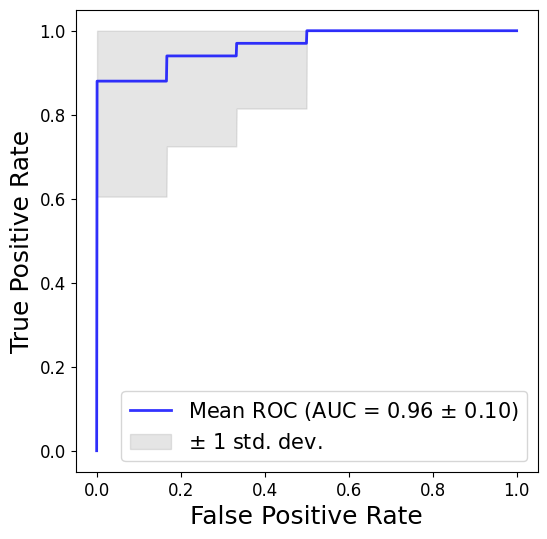

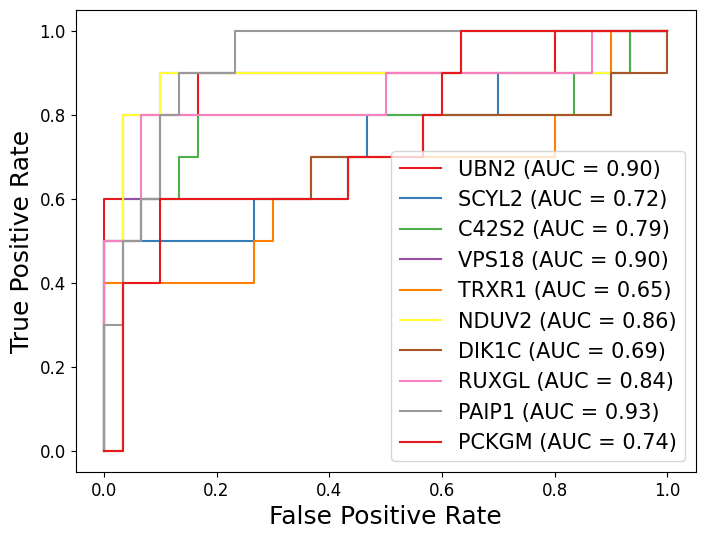

<Figure size 600x600 with 0 Axes>

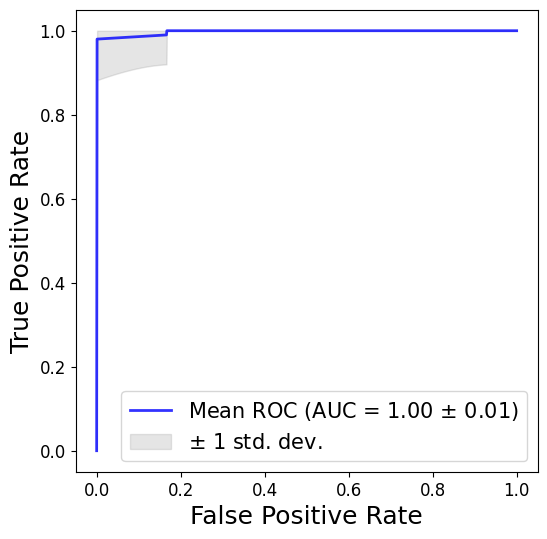

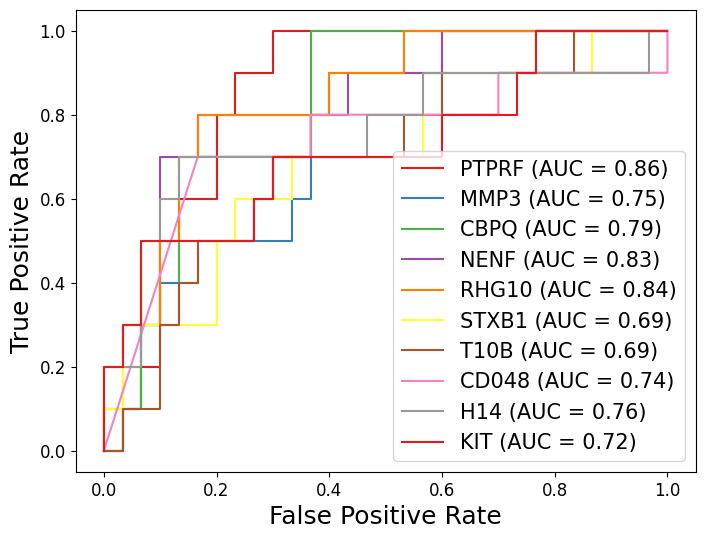

<Figure size 600x600 with 0 Axes>

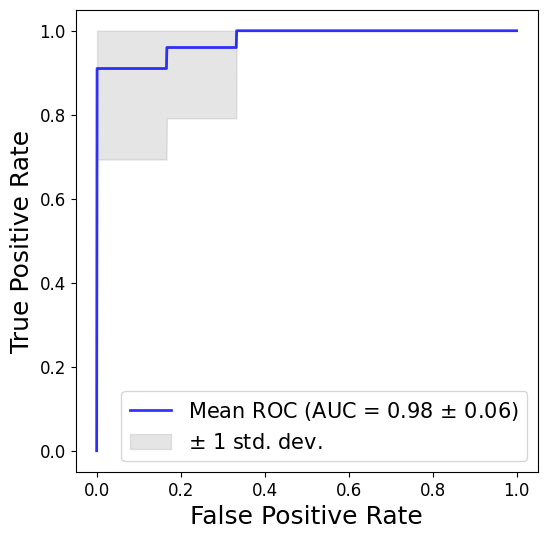

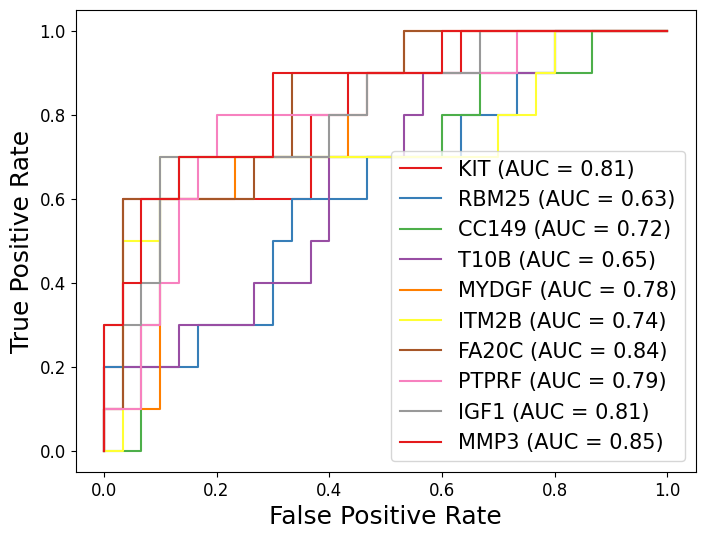

<Figure size 600x600 with 0 Axes>

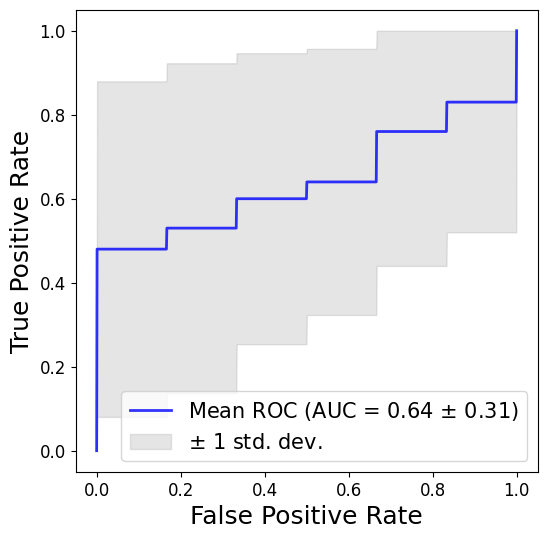

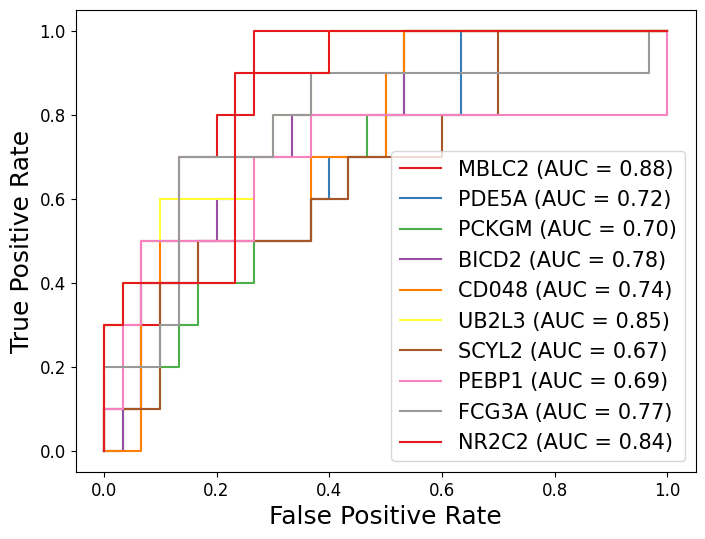

<Figure size 600x600 with 0 Axes>

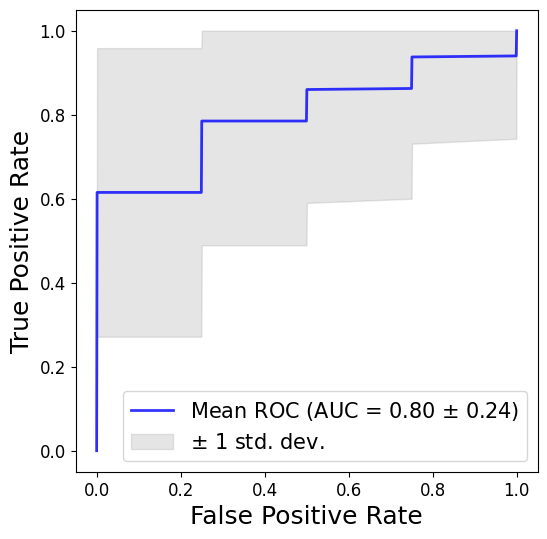

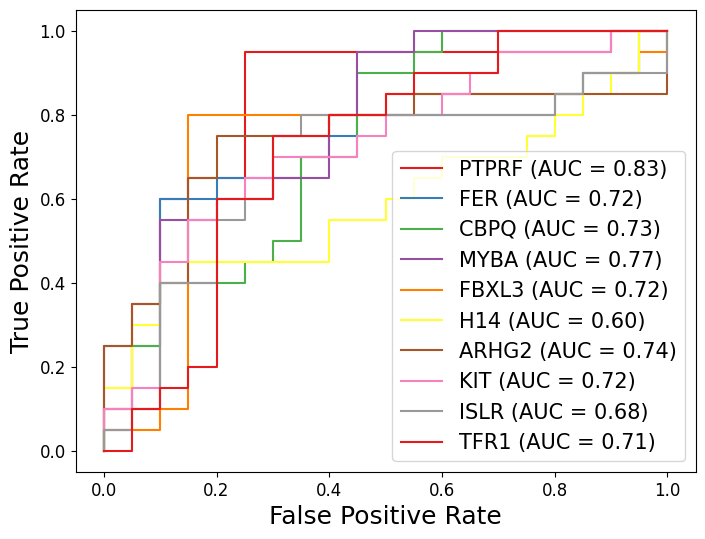

<Figure size 600x600 with 0 Axes>

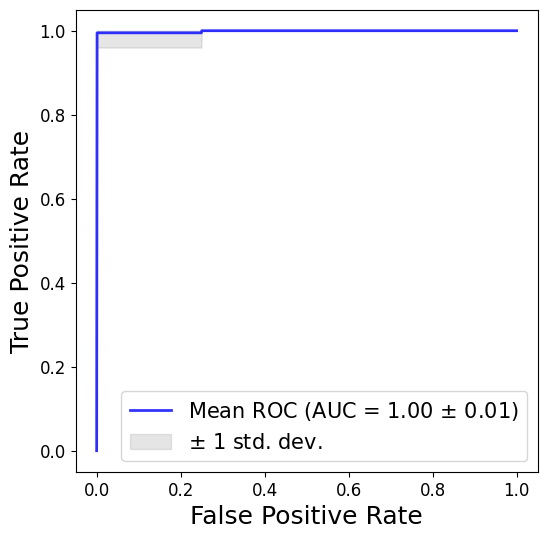

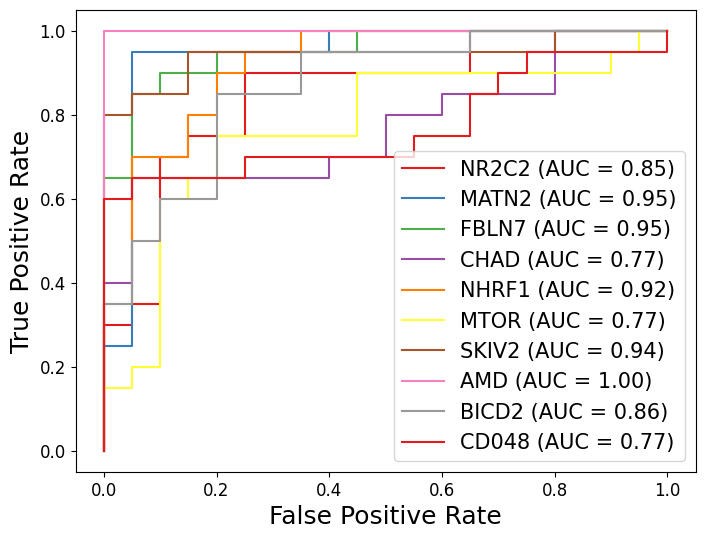

In [7]:
# For each of the 6 binary classification tasks of interest, cross-validate a linear SVM for seperating the two classes
# And plot the ROCs of the features assigned the highest weight by the classifier

target_labels = [['AD'], ['PDD'], ['PD-noMCI'], ['HC'], ['PDD', 'AD'], ['PDD', 'PD-noMCI']]

for cur_target_labels in target_labels:

  cur_y = np.array([label in cur_target_labels for label in y])

  n_splits = 5
  n_repeats = 10
  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  clf = svm.SVC(kernel='linear', probability=True, C=2**7, random_state=1966)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 1000)

  _, garbage_ax = plt.subplots(figsize=(6, 6))
  fig, ax = plt.subplots(figsize=(6, 6))

  feature_ranks = np.zeros((X.shape[1], n_repeats*n_splits))

  #Run n-fold cross validation
  step = 0
  accs = []
  y_trues = []
  y_preds = []
  for fold, (train, test) in enumerate(cv.split(X, cur_y)):
      scaler = preprocessing.StandardScaler().fit(X[train])
      clf.fit(scaler.transform(X[train]), cur_y[train])
      viz = RocCurveDisplay.from_estimator(
          clf,
          scaler.transform(X[test]),
          cur_y[test],
          alpha=0.5,
          lw=1,
          ax=garbage_ax
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

      preds = clf.predict(scaler.transform(X[test]))
      accs.append(np.mean(preds == cur_y[test]))
      y_trues = np.concatenate([y_trues, cur_y[test]])
      y_preds = np.concatenate([y_preds, preds])

      weights = clf.coef_[0]
      ordered = np.argsort(weights)[::-1]
      for idx, feature in enumerate(ordered):
        feature_ranks[feature, step] = idx

      step += 1

  # Find the 10 features consistently given the highest model weights across folds
  mean_feature_ranks = np.mean(feature_ranks, axis=1)
  top_5 = np.argsort(mean_feature_ranks)[:5]
  bottom_5 = np.argsort(mean_feature_ranks)[-5:]

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      xlabel="False Positive Rate",
      ylabel="True Positive Rate"
  )
  ax.axis("square")
  ax.tick_params(axis='both', which='major', labelsize=12)

  handles, labels = ax.get_legend_handles_labels()
  handles = handles[-2:]
  labels = labels[-2:]
  by_label = dict(zip(labels, handles))
  ax.legend(by_label.values(), by_label.keys(), loc="lower right")
  garbage_ax.remove()

  plt.savefig(f"{'_and_'.join([condition_to_plot_label[x] for x in cur_target_labels])}_vs_ALL")

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
  fdr_fig, fdr_ax = plt.subplots(figsize=(8, 6))
  for idx in top_5:
    RocCurveDisplay.from_predictions(
      [int(x) for x in cur_y],
      data.iloc[idx].values[sample_idxs],
      name=f"{data.iloc[idx].values[0].split(' ')[0].split('|')[-1].split('_')[0]}",
      ax=fdr_ax
    )

  for idx in bottom_5:
    RocCurveDisplay.from_predictions(
      [int(x) for x in cur_y],
      -1*data.iloc[idx].values[sample_idxs],
      name=f"{data.iloc[idx].values[0].split(' ')[0].split('|')[-1].split('_')[0]}",
      ax=fdr_ax
   )
  fdr_ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      xlabel="False Positive Rate",
      ylabel="True Positive Rate"
  )
  fdr_ax.tick_params(axis='both', which='major', labelsize=12)
  plt.savefig(f"{'_and_'.join([condition_to_plot_label[x] for x in cur_target_labels])}_vs_ALL_features")



0.8


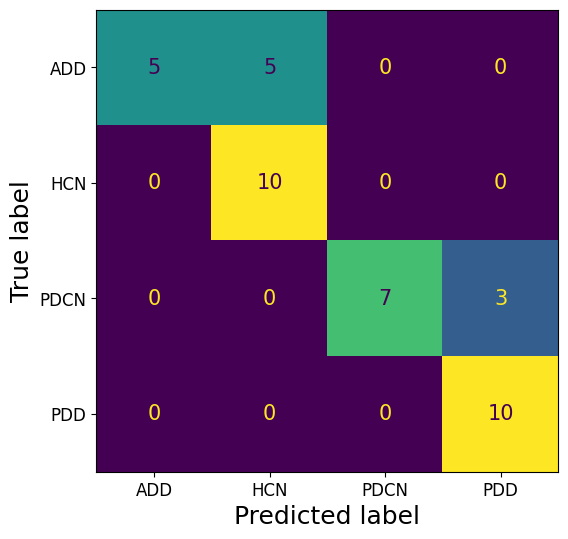

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot a confusion matrix for 4-way model predictions across all validation splits

n_splits = 10
n_repeats = 1
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
clf = svm.SVC(kernel='linear', probability=True, C=2**50, random_state=1966, class_weight={'HC': 1, 'AD': 1})

accs = []
y_trues = []
y_preds = []
for fold, (train, test) in enumerate(cv.split(X, y)):
    scaler = preprocessing.StandardScaler().fit(X[train])
    clf.fit(scaler.transform(X[train]), y[train])
    preds = clf.predict(scaler.transform(X[test]))
    accs.append(np.mean(preds == y[test]))
    y_trues = np.concatenate([y_trues, y[test]])
    y_preds = np.concatenate([y_preds, preds])

fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': 'Helvetica'})
ConfusionMatrixDisplay.from_predictions([condition_to_plot_label[x] for x in  y_trues], [condition_to_plot_label[x] for x in y_preds], ax=ax, colorbar=False)
# ax.set_title('Confusion matrix for 4 way classification \n Accuracy: ' + str(np.mean(np.array(y_trues) == np.array(y_preds))) + '%')

ax.tick_params(axis='both', which='major', labelsize=12)

print(np.mean(accs))



In [10]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

# Compute a table of ROCs (and assosciated q-values) for each feature and each prediction task

def calc_feature_sig(labeled_X, y):
  U1, p = mannwhitneyu(labeled_X[y], labeled_X[[not i for i in y]], axis=0)
  rej, fdrs = fdrcorrection(p, alpha=0.05)
  return U1/(sum(y)*(len(y) - sum(y))), rej, fdrs

roc_df = pd.DataFrame()
roc_df['Protein Name'] = data.iloc[:,0]
roc_df['Gene Name'] = [x.split(' ')[0].split('|')[-1].split('_')[0] for x in data.iloc[:,0]]


target_labels = [['AD'], ['PDD'], ['PD-noMCI'], ['HC'], ['PDD', 'AD'], ['PDD', 'PD-noMCI']]

for cur_target_label in target_labels:
  cur_y = np.array([label in cur_target_label for label in y])
  roc, rej, fdrs = calc_feature_sig(np.array(data.values[:,1:], dtype=float).T, cur_y)
  direction = ['increased' if x > 0.5 else 'decreased' for x in roc]
  roc = [max(x, 1-x) for x in roc]
  roc_df[' and '.join(cur_target_label) + " ROC"] = roc
  roc_df[' and '.join(cur_target_label) + " q-value"] = fdrs
  roc_df[' and '.join(cur_target_label) + " direction"] = direction
  name = f"ROC curves for top ten proteins selected by classifier \n {' and '.join(cur_target_label)} vs ALL"

print(roc_df)


               Protein Name Gene Name    AD ROC  AD q-value AD direction  \
0     sp|O15194|CTDSL_HUMAN     CTDSL  0.630000    0.438294    decreased   
1      sp|O95445|APOM_HUMAN      APOM  0.533333    0.875823    increased   
2     sp|P21281|VATB2_HUMAN     VATB2  0.673333    0.285793    decreased   
3      sp|P23919|KTHY_HUMAN      KTHY  0.566667    0.715258    decreased   
4      sp|P36551|HEM6_HUMAN      HEM6  0.613333    0.500800    increased   
...                     ...       ...       ...         ...          ...   
2338  sp|Q13554|KCC2B_HUMAN     KCC2B  0.590000    0.604774    decreased   
2339   sp|Q13642|FHL1_HUMAN      FHL1  0.623333    0.466139    decreased   
2340   sp|Q3ZCW2|LEGL_HUMAN      LEGL  0.530000    0.883377    increased   
2341  sp|Q6DHV5|C2D2B_HUMAN     C2D2B  0.693333    0.225272    increased   
2342   sp|P00924|ENO1_YEAST      ENO1  0.566667    0.715258    increased   

       PDD ROC  PDD q-value PDD direction  PD-noMCI ROC  PD-noMCI q-value  \
0     0.73

In [ ]:
roc_df.to_csv('mag-net_biomarker_rocs.csv')